In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Загрузка данных Амазона
df = pd.read_csv('exel_files/amazon_delivery.csv')

#Преобразование типов данных
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Order_Time'] = pd.to_datetime(df['Order_Time'], format='%H:%M:%S', errors='coerce').dt.time
df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'], format='%H:%M:%S', errors='coerce').dt.time

#Обработка пропущенных значений
df.dropna(inplace=True)

## 1. Корреляционный анализ

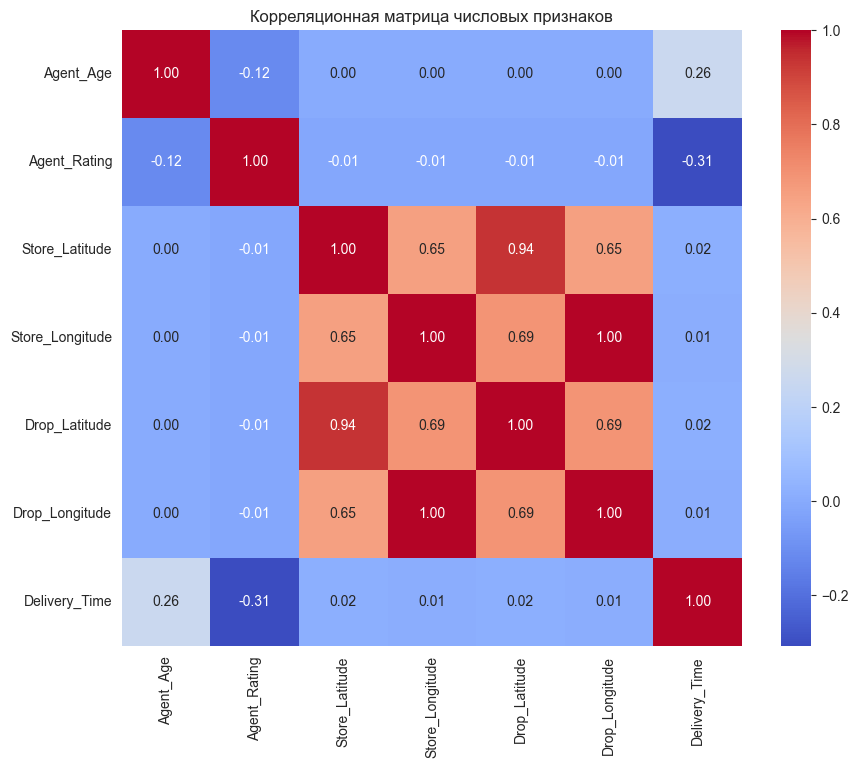

Корреляция с Delivery_Time:
Delivery_Time      1.000000
Agent_Age          0.258463
Drop_Latitude      0.017279
Store_Latitude     0.016890
Drop_Longitude     0.012287
Store_Longitude    0.011805
Agent_Rating      -0.307725
Name: Delivery_Time, dtype: float64


In [41]:
#Вычисление корреляционной матрицы для числовых признаков
numerical_features = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

print('Корреляция с Delivery_Time:')
print(correlation_matrix['Delivery_Time'].sort_values(ascending=False))

## 2. Влияние категориальных признаков на время доставки

### 2.1. Влияние категории товаров

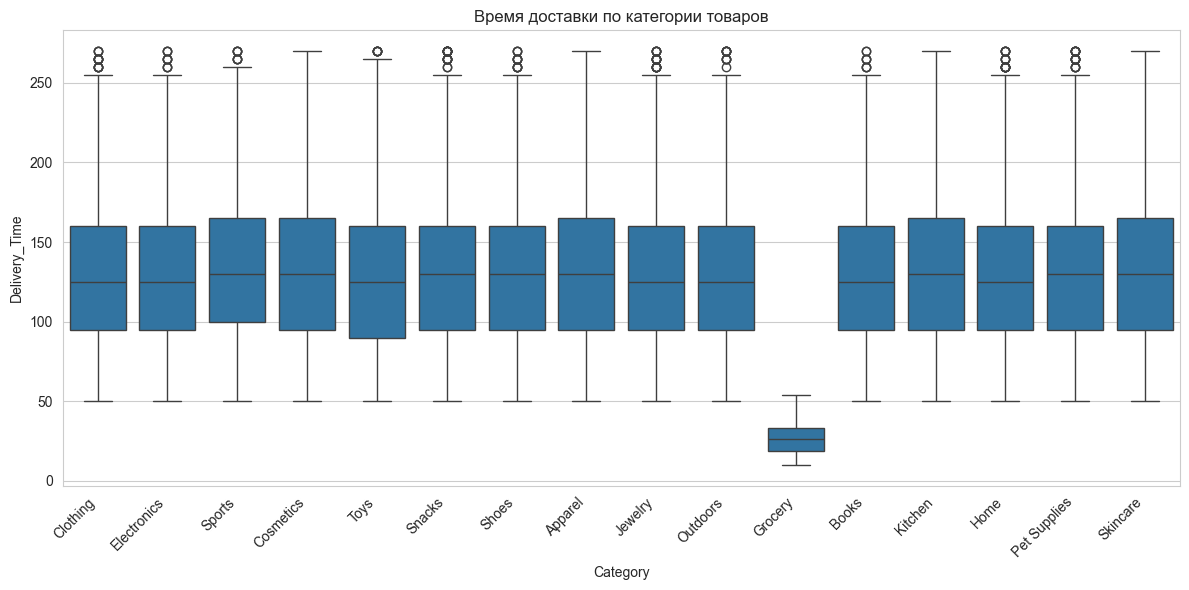

In [42]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='Delivery_Time', data=df)
plt.title('Время доставки по категории товаров')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.2 Влияние типа транспортного средства

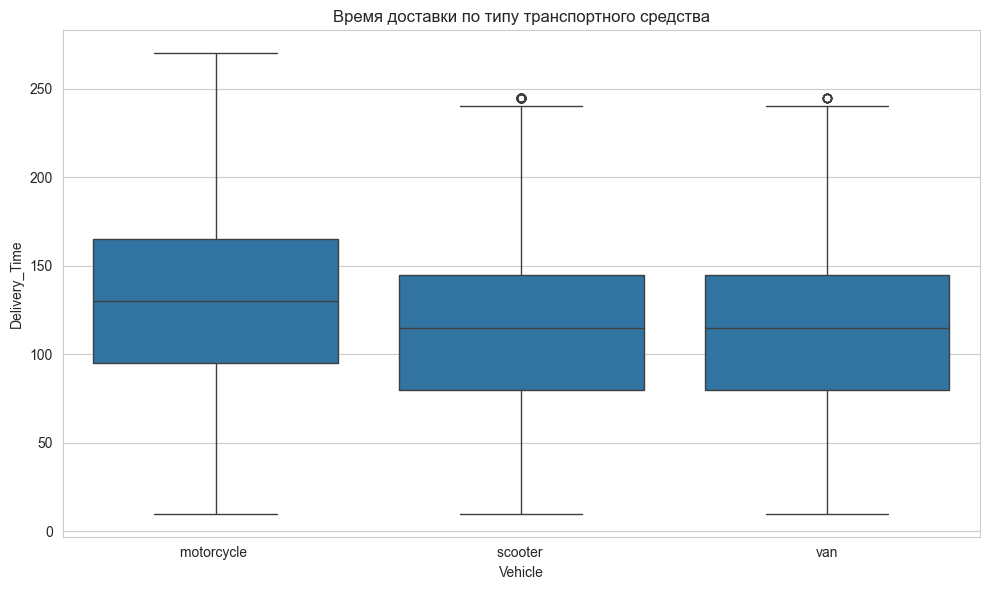

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Vehicle', y='Delivery_Time', data=df)
plt.title('Время доставки по типу транспортного средства')
plt.tight_layout()
plt.show()

### 2.3. Влияние погоды

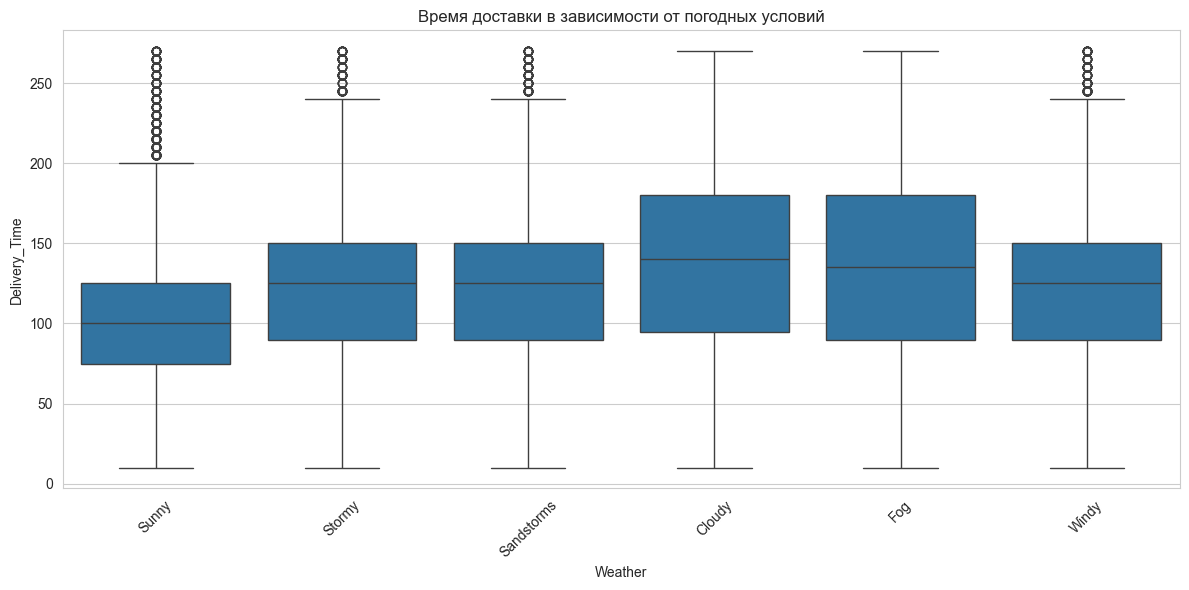

In [44]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Weather', y='Delivery_Time', data=df)
plt.title('Время доставки в зависимости от погодных условий')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.4. Влияние трафика

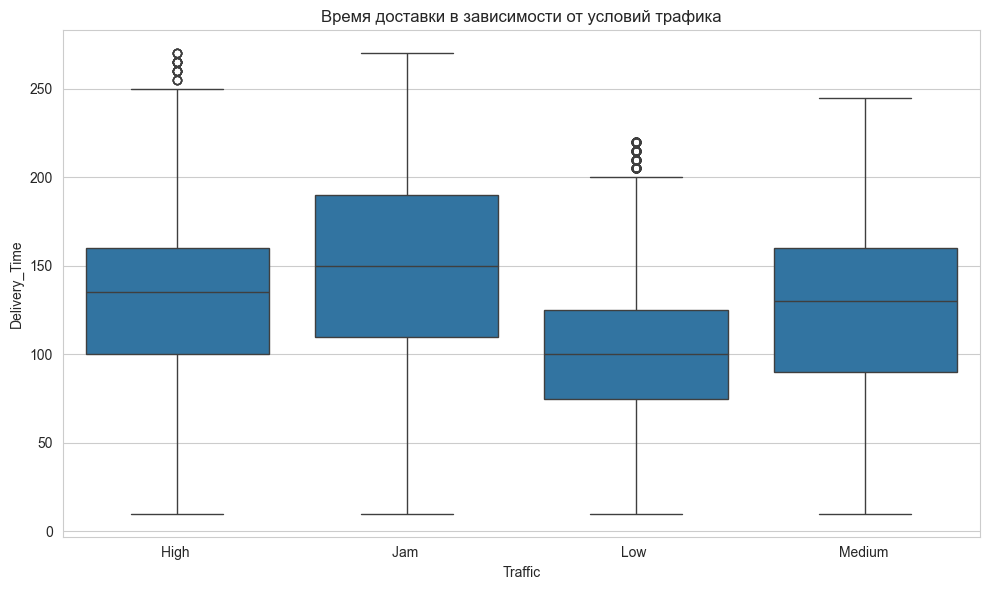

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Traffic', y='Delivery_Time', data=df)
plt.title('Время доставки в зависимости от условий трафика')
plt.tight_layout()
plt.show()

### 2.5. Подготовка данных для моделей

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from math import radians, sin, cos, sqrt, atan2

#Установка стиля для графиков
sns.set_style('whitegrid')

#Удаление не используемых столбцов
df.dropna(inplace=True)
df.drop(columns=['Order_ID', 'Order_Date', 'Order_Time', 'Pickup_Time'], inplace=True)

#Расчет расстояния (Формула Гаверсинуса) - Ключевой признак
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 #Радиус Земли в км
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

df['Distance_km'] = df.apply(
    lambda row: haversine(row['Store_Latitude'], row['Store_Longitude'], row['Drop_Latitude'], row['Drop_Longitude']),
    axis=1
)

#Удаление координат после расчета расстояния
df.drop(columns=['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude'], inplace=True)


## 3. Прогнозирование времени доставки (Регрессия)

### 3.1 Создание нового признака для классификация: 'Is_Late' Порог задержки: более 75-го перцентиля времени доставки

In [47]:
delay_threshold = df['Delivery_Time'].quantile(0.75)
df['Is_Late'] = (df['Delivery_Time'] > delay_threshold).astype(int)
print(f'Порог задержки (75-й перцинтель) установлен на: {delay_threshold:.2f} минут.')
df.head()

Порог задержки (75-й перцинтель) установлен на: 160.00 минут.


,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance_km,Is_Late
0,37,4.9,Sunny,High,motorcycle,Urban,120,Clothing,157.167163,0
1,34,4.5,Stormy,Jam,scooter,Metropolitian,165,Electronics,1122.805145,1
2,23,4.4,Sandstorms,Low,motorcycle,Urban,130,Sports,87.367285,0
3,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,318.624865,0
4,32,4.6,Cloudy,High,scooter,Metropolitian,150,Toys,344.620929,0


In [51]:
#Целевая переменная: Delivery_Time
X = df.drop(columns=['Delivery_Time', 'Is_Late'])
y = df['Delivery_Time']
print("Финальные колонки X для модели:", X.columns.tolist())
#Определение типов признака
numerical_fetures = ['Agent_Age', 'Agent_Rating', 'Distance_km']
categorical_features = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']

#конвейер предобработки (Pipeline)
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

Финальные колонки X для модели: ['Agent_Age', 'Agent_Rating', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Category', 'Distance_km']


In [50]:
#Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

#Применение предобработки
X_train_reg_processed = preprocessor_reg.fit_transform(X_train_reg)
X_test_reg_processed = preprocessor_reg.transform(X_test_reg)

#Обучение модели (Random Forest Regressor)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train_reg_processed, y_train_reg)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed